In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load your file
df = pd.read_csv("C:/Users/Admin/Downloads/ott_churn_5000.csv")

df.info()
df.head()
df.describe(include='all')
print("\n✅ Data Imported")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                5000 non-null   object 
 1   signup_date                5000 non-null   object 
 2   last_activity_date         5000 non-null   object 
 3   age                        5000 non-null   int64  
 4   gender                     5000 non-null   object 
 5   country                    5000 non-null   object 
 6   plan                       5000 non-null   object 
 7   monthly_price              5000 non-null   float64
 8   contract_type              5000 non-null   object 
 9   payment_method             5000 non-null   object 
 10  avg_watch_minutes_per_day  5000 non-null   float64
 11  sessions_per_week          5000 non-null   float64
 12  devices                    5000 non-null   object 
 13  fav_genre                  5000 non-null   objec

In [2]:
#Data Cleaning
# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Handle missing values
print("\nMissing values:")
print(df.isnull().sum())

# Convert date columns to datetime
date_columns = ['signup_date', 'last_activity_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values strategically
# For numerical columns - use median/mean based on distribution
df['avg_watch_minutes_per_day']=df['avg_watch_minutes_per_day'].fillna(df['avg_watch_minutes_per_day'].median())
df['sessions_per_week']=df['sessions_per_week'].fillna(df['sessions_per_week'].median())

# For categorical columns - use mode or 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    mode_value=df[col].mode()
    fill_value=mode_value[0] if not mode_value.empty else 'Unknown'
    df[col]=df[col].fillna(fill_value)

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to key numerical columns
numerical_cols = ['monthly_price', 'avg_watch_minutes_per_day', 'sessions_per_week']
for col in numerical_cols:
    df = remove_outliers(df, col)

print("\nData after cleaning:")
print(df.info())

Duplicate rows: 0

Missing values:
customer_id                  0
signup_date                  0
last_activity_date           0
age                          0
gender                       0
country                      0
plan                         0
monthly_price                0
contract_type                0
payment_method               0
avg_watch_minutes_per_day    0
sessions_per_week            0
devices                      0
fav_genre                    0
num_profiles                 0
watched_in_last_30_days      0
hours_last_30_days           0
num_support_tickets          0
num_complaints               0
acq_channel                  0
first_campaign               0
internet_speed_mbps          0
app_crash_rate_per_week      0
tenure_days                  0
tenure_months                0
rfm_recency_days             0
frequency_per_month          0
avg_monthly_spend            0
total_revenue_to_date        0
churn                        0
dtype: int64

Data after cleaning:


In [3]:
#FEATURE ENGINEERING
# Create temporal features
df['customer_lifetime_days'] = (df['last_activity_date'] - df['signup_date']).dt.days
df['signup_month'] = df['signup_date'].dt.month
df['signup_year'] = df['signup_date'].dt.year
df['days_since_last_activity'] = (pd.Timestamp.now() - df['last_activity_date']).dt.days

# Engagement score (composite metric)
df['engagement_score'] = (
    df['avg_watch_minutes_per_day'] * 0.4 +
    df['sessions_per_week'] * 10 * 0.3 +
    df['watched_in_last_30_days'] * 0.3
)

# Revenue metrics
df['total_lifetime_value'] = df['monthly_price'] * df['tenure_months']
df['avg_revenue_per_day'] = df['total_revenue_to_date'] / df['customer_lifetime_days'].replace(0, 1)

# Device diversity
df['device_count'] = df['devices'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Content consumption patterns
df['hours_per_session'] = df['hours_last_30_days'] / (df['sessions_per_week'] * 4).replace(0, 1)
df['watch_intensity'] = pd.cut(df['avg_watch_minutes_per_day'], 
                                bins=[0, 30, 60, 120, float('inf')],
                                labels=['Low', 'Medium', 'High', 'Very High'])

# Customer segments
df['customer_segment'] = pd.cut(df['tenure_months'],
                                bins=[0, 3, 12, 24, float('inf')],
                                labels=['New', 'Growing', 'Mature', 'Loyal'])

# Risk indicators
df['churn_risk_score'] = (
    (df['days_since_last_activity'] > 30).astype(int) * 30 +
    (df['num_complaints'] > 2).astype(int) * 25 +
    (df['avg_watch_minutes_per_day'] < 15).astype(int) * 25 +
    (df['app_crash_rate_per_week'] > 2).astype(int) * 20
)

df['is_high_value_customer'] = (df['total_revenue_to_date'] > df['total_revenue_to_date'].quantile(0.75)).astype(int)
df['is_power_user'] = (df['avg_watch_minutes_per_day'] > df['avg_watch_minutes_per_day'].quantile(0.75)).astype(int)

# Behavioral flags
df['is_dormant'] = (df['days_since_last_activity'] > 30).astype(int)
df['is_multi_device_user'] = (df['device_count'] > 1).astype(int)
df['has_support_issues'] = (df['num_support_tickets'] > 0).astype(int)

print("\nNew features created:")
print(df.columns.tolist())


New features created:
['customer_id', 'signup_date', 'last_activity_date', 'age', 'gender', 'country', 'plan', 'monthly_price', 'contract_type', 'payment_method', 'avg_watch_minutes_per_day', 'sessions_per_week', 'devices', 'fav_genre', 'num_profiles', 'watched_in_last_30_days', 'hours_last_30_days', 'num_support_tickets', 'num_complaints', 'acq_channel', 'first_campaign', 'internet_speed_mbps', 'app_crash_rate_per_week', 'tenure_days', 'tenure_months', 'rfm_recency_days', 'frequency_per_month', 'avg_monthly_spend', 'total_revenue_to_date', 'churn', 'customer_lifetime_days', 'signup_month', 'signup_year', 'days_since_last_activity', 'engagement_score', 'total_lifetime_value', 'avg_revenue_per_day', 'device_count', 'hours_per_session', 'watch_intensity', 'customer_segment', 'churn_risk_score', 'is_high_value_customer', 'is_power_user', 'is_dormant', 'is_multi_device_user', 'has_support_issues']


✓ Converted 'churn' to binary (Yes=1, No=0)
✓ Created 'customer_segment' feature

Churn Rate: 39.45%
Churn value counts:
churn
0    3007
1    1959
Name: count, dtype: int64


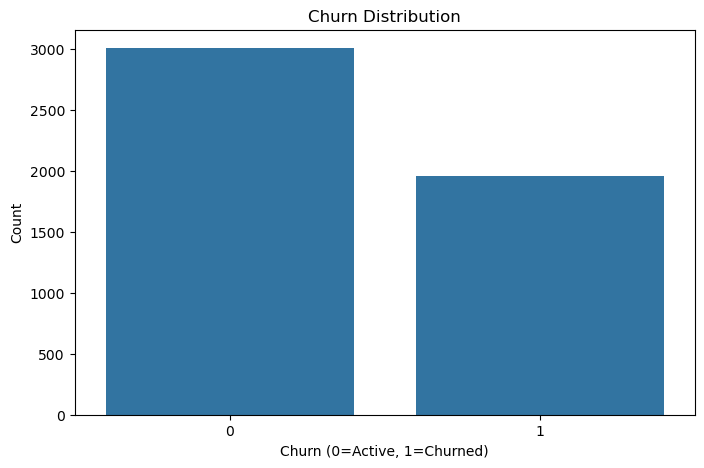

Churn Rate: 39.45%


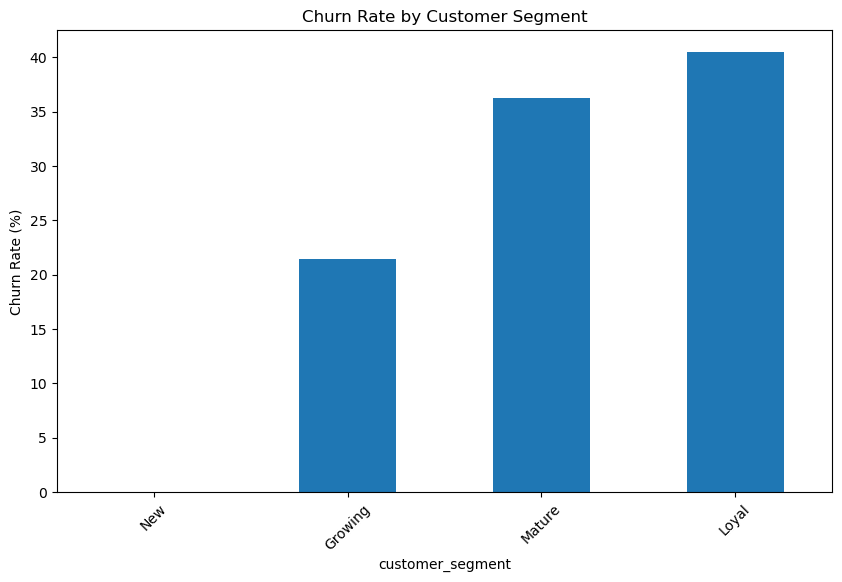

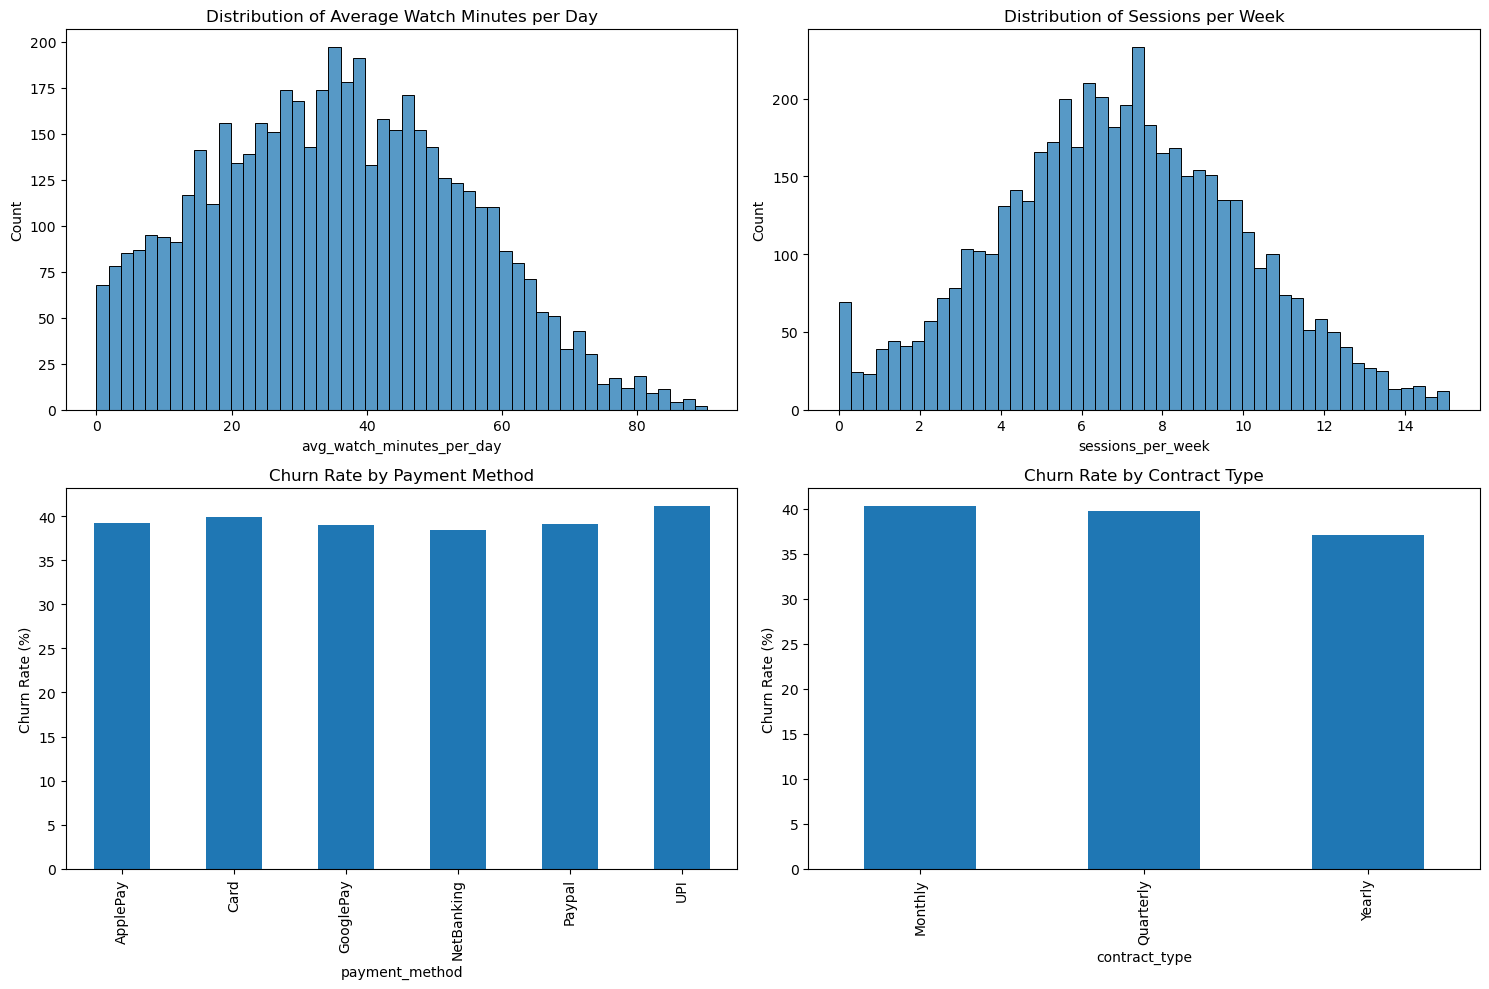

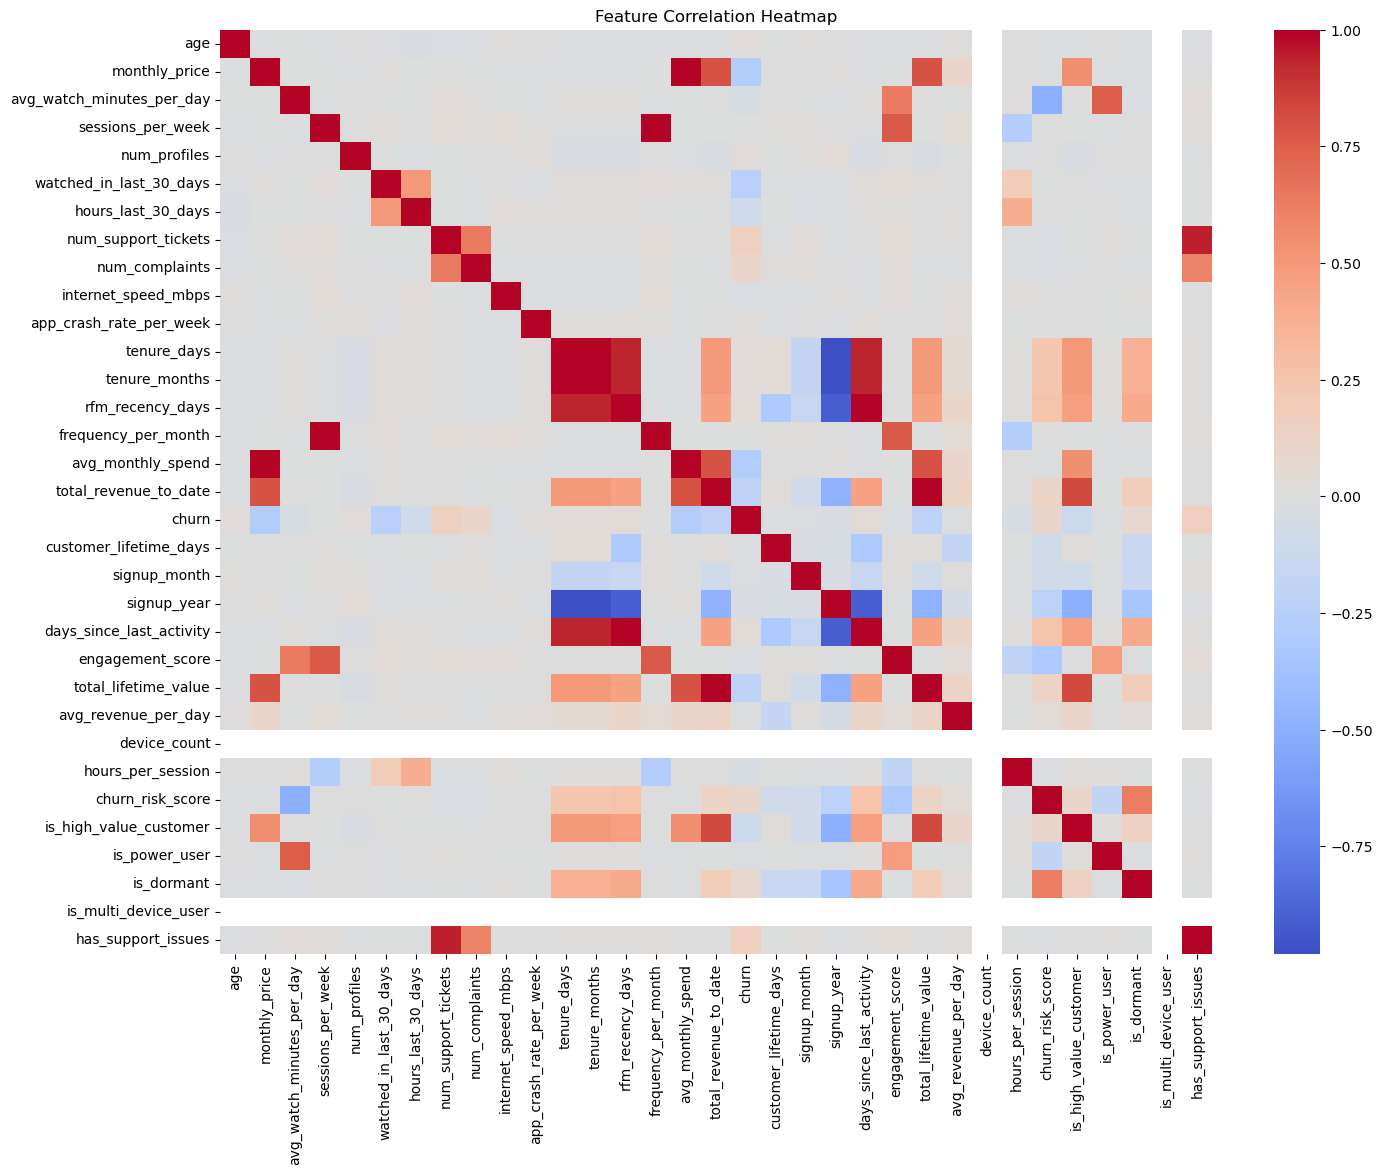


=== Key Metrics by Churn Status ===
       avg_watch_minutes_per_day  sessions_per_week  monthly_price  \
churn                                                                
0                          36.29               6.94         482.79   
1                          34.89               6.93         325.61   

       tenure_months  num_complaints  num_support_tickets  \
churn                                                       
0              40.96            0.06                 0.15   
1              42.11            0.12                 0.30   

       total_revenue_to_date  
churn                         
0                   19775.19  
1                   13599.25  


In [4]:
#EXPLORATORY DATA ANALYSIS

# Convert Yes/No columns to binary (0/1) 
for col in df.columns:
    if df[col].dtype == 'object':
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) <= 2 and set([str(v).lower() for v in unique_vals]).issubset({'yes', 'no'}):
            df[col] = df[col].str.lower().map({'yes': 1, 'no': 0})
            print(f"✓ Converted '{col}' to binary (Yes=1, No=0)")

#  Create customer_segment feature BEFORE using it
df['customer_segment'] = pd.cut(df['tenure_months'],
                                bins=[0, 3, 12, 24, float('inf')],
                                labels=['New', 'Growing', 'Mature', 'Loyal'])
print("✓ Created 'customer_segment' feature")

# Verify churn column conversion
print(f"\nChurn Rate: {df['churn'].mean()*100:.2f}%")
print(f"Churn value counts:\n{df['churn'].value_counts()}")

# 1. Churn Distribution
plt.figure(figsize=(8, 5))
churn_counts = df['churn'].value_counts()
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.title('Churn Distribution')
plt.xlabel('Churn (0=Active, 1=Churned)')
plt.ylabel('Count')
plt.show()

print(f"Churn Rate: {df['churn'].mean()*100:.2f}%")

# 2. Churn by Customer Segment 
plt.figure(figsize=(10, 6))
segment_churn = df.groupby('customer_segment', observed=False)['churn'].mean() * 100
segment_churn.plot(kind='bar')
plt.title('Churn Rate by Customer Segment')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()

# 3. Engagement patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Watch time distribution
sns.histplot(df['avg_watch_minutes_per_day'], bins=50, ax=axes[0,0])
axes[0,0].set_title('Distribution of Average Watch Minutes per Day')

# Sessions per week
sns.histplot(df['sessions_per_week'], bins=50, ax=axes[0,1])
axes[0,1].set_title('Distribution of Sessions per Week')

# Churn by payment method 
payment_churn = df.groupby('payment_method', observed=False)['churn'].mean() * 100
payment_churn.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Churn Rate by Payment Method')
axes[1,0].set_ylabel('Churn Rate (%)')

# Churn by contract type 
contract_churn = df.groupby('contract_type', observed=False)['churn'].mean() * 100
contract_churn.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Churn Rate by Contract Type')
axes[1,1].set_ylabel('Churn Rate (%)')

plt.tight_layout()
plt.show()

# 4. Correlation analysis
numerical_features = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

# 5. Key metrics by churn status 
print("\n=== Key Metrics by Churn Status ===")
churn_comparison = df.groupby('churn', observed=False).agg({
    'avg_watch_minutes_per_day': 'mean',
    'sessions_per_week': 'mean',
    'monthly_price': 'mean',
    'tenure_months': 'mean',
    'num_complaints': 'mean',
    'num_support_tickets': 'mean',
    'total_revenue_to_date': 'mean'
}).round(2)
print(churn_comparison)


                    OTT PLATFORM - KEY PERFORMANCE INDICATORS
Total Customers.............................................           4,966
Active Customers............................................           3,007
Churned Customers...........................................           1,959
Churn Rate (%)..............................................           39.45
Retention Rate (%)..........................................           60.55
Total Revenue ($)...........................................   86,104,907.89
Avg Revenue Per User (ARPU) ($).............................          420.78
Revenue from Active ($).....................................   59,463,983.72
Revenue Lost from Churn ($).................................   26,640,924.17
Avg Customer Lifetime Value ($).............................       17,338.76
Avg Watch Minutes/Day.......................................           35.74
Avg Sessions/Week...........................................            6.94
Avg Hours Las

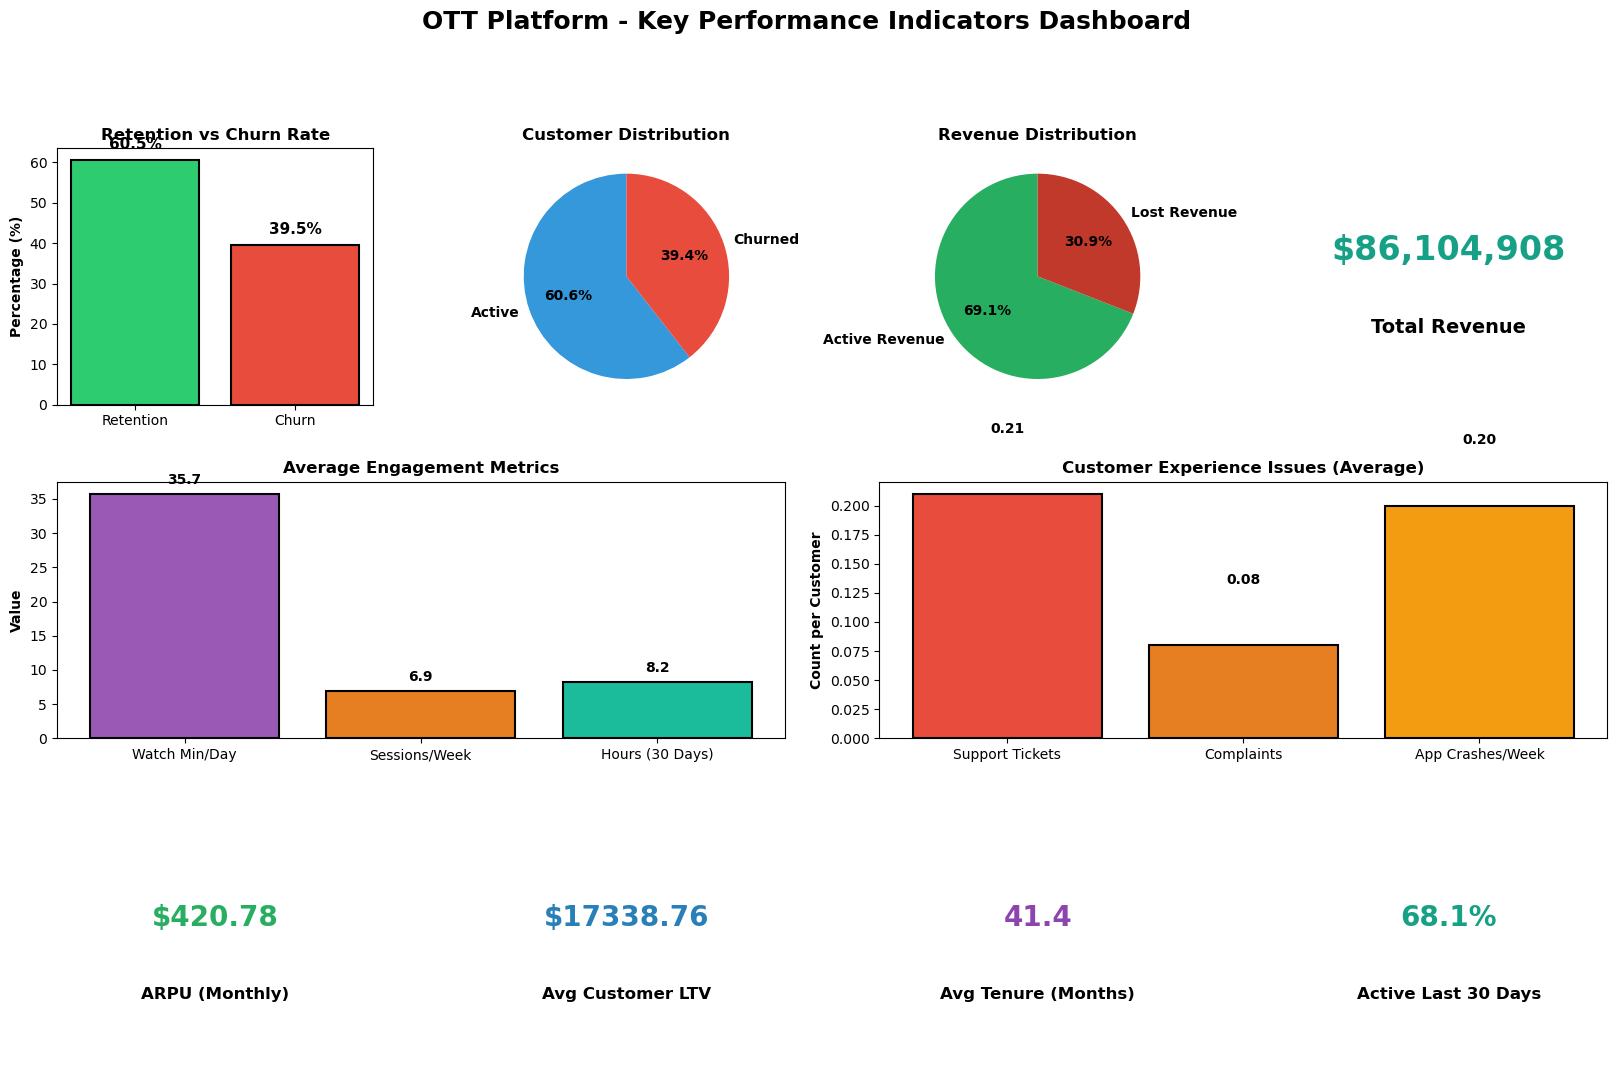


✓ KPI Dashboard created successfully!


In [6]:
# ===== KEY PERFORMANCE INDICATORS (KPIs) =====

def calculate_kpis(df):
    """Calculate all key performance indicators"""
    kpis = {}
    
    # Customer Metrics
    kpis['Total Customers'] = len(df)
    kpis['Active Customers'] = len(df[df['churn'] == 0])
    kpis['Churned Customers'] = len(df[df['churn'] == 1])
    kpis['Churn Rate (%)'] = (df['churn'].mean() * 100).round(2)
    kpis['Retention Rate (%)'] = ((1 - df['churn'].mean()) * 100).round(2)
    
    # Revenue Metrics
    kpis['Total Revenue ($)'] = df['total_revenue_to_date'].sum().round(2)
    kpis['Avg Revenue Per User (ARPU) ($)'] = df['monthly_price'].mean().round(2)
    kpis['Revenue from Active ($)'] = df[df['churn']==0]['total_revenue_to_date'].sum().round(2)
    kpis['Revenue Lost from Churn ($)'] = df[df['churn']==1]['total_revenue_to_date'].sum().round(2)
    kpis['Avg Customer Lifetime Value ($)'] = (df['monthly_price'] * df['tenure_months']).mean().round(2)
    
    # Engagement Metrics
    kpis['Avg Watch Minutes/Day'] = df['avg_watch_minutes_per_day'].mean().round(2)
    kpis['Avg Sessions/Week'] = df['sessions_per_week'].mean().round(2)
    kpis['Avg Hours Last 30 Days'] = df['hours_last_30_days'].mean().round(2)
    kpis['Active Users Last 30 Days (%)'] = ((df['watched_in_last_30_days'] > 0).mean() * 100).round(2)
    
    # Customer Experience
    kpis['Avg Support Tickets per Customer'] = df['num_support_tickets'].mean().round(2)
    kpis['Avg Complaints per Customer'] = df['num_complaints'].mean().round(2)
    kpis['Avg App Crashes/Week'] = df['app_crash_rate_per_week'].mean().round(2)
    
    # Tenure Metrics
    kpis['Avg Customer Tenure (Months)'] = df['tenure_months'].mean().round(2)
    kpis['Avg Customer Tenure (Days)'] = df['tenure_days'].mean().round(2)
    
    return kpis

# Calculate KPIs
kpis = calculate_kpis(df)

# Display KPIs
print("\n" + "="*80)
print(" "*20 + "OTT PLATFORM - KEY PERFORMANCE INDICATORS")
print("="*80)
for key, value in kpis.items():
    if isinstance(value, float):
        print(f"{key:.<60} {value:>15,.2f}")
    else:
        print(f"{key:.<60} {value:>15,}")
print("="*80)

# Visualize KPIs
fig = plt.figure(figsize=(20, 12))
fig.suptitle('OTT Platform - Key Performance Indicators Dashboard', fontsize=18, fontweight='bold', y=0.995)

# Create grid
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# KPI 1: Churn vs Retention
ax1 = fig.add_subplot(gs[0, 0])
values = [kpis['Retention Rate (%)'], kpis['Churn Rate (%)']]
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(['Retention', 'Churn'], values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title('Retention vs Churn Rate', fontweight='bold', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontweight='bold')
for i, (bar, v) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# KPI 2: Customer Distribution
ax2 = fig.add_subplot(gs[0, 1])
sizes = [kpis['Active Customers'], kpis['Churned Customers']]
colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax2.pie(sizes, labels=['Active', 'Churned'], autopct='%1.1f%%',
                                     colors=colors, startangle=90, textprops={'fontweight': 'bold'})
ax2.set_title('Customer Distribution', fontweight='bold', fontsize=12)

# KPI 3: Revenue Distribution
ax3 = fig.add_subplot(gs[0, 2])
revenue_data = [kpis['Revenue from Active ($)'], kpis['Revenue Lost from Churn ($)']]
colors = ['#27ae60', '#c0392b']
wedges, texts, autotexts = ax3.pie(revenue_data, labels=['Active Revenue', 'Lost Revenue'],
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     textprops={'fontweight': 'bold'})
ax3.set_title('Revenue Distribution', fontweight='bold', fontsize=12)

# KPI 4: Total Revenue
ax4 = fig.add_subplot(gs[0, 3])
ax4.text(0.5, 0.6, f"${kpis['Total Revenue ($)']:,.0f}", ha='center', va='center',
         fontsize=24, fontweight='bold', color='#16a085', transform=ax4.transAxes)
ax4.text(0.5, 0.3, 'Total Revenue', ha='center', va='center',
         fontsize=14, fontweight='bold', transform=ax4.transAxes)
ax4.axis('off')

# KPI 5: Engagement Metrics
ax5 = fig.add_subplot(gs[1, 0:2])
engagement_metrics = ['Watch Min/Day', 'Sessions/Week', 'Hours (30 Days)']
engagement_values = [kpis['Avg Watch Minutes/Day'], 
                     kpis['Avg Sessions/Week'], 
                     kpis['Avg Hours Last 30 Days']]
colors = ['#9b59b6', '#e67e22', '#1abc9c']
bars = ax5.bar(engagement_metrics, engagement_values, color=colors, edgecolor='black', linewidth=1.5)
ax5.set_title('Average Engagement Metrics', fontweight='bold', fontsize=12)
ax5.set_ylabel('Value', fontweight='bold')
for bar, v in zip(bars, engagement_values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# KPI 6: Customer Experience Issues
ax6 = fig.add_subplot(gs[1, 2:4])
issues = ['Support Tickets', 'Complaints', 'App Crashes/Week']
issues_values = [kpis['Avg Support Tickets per Customer'],
                 kpis['Avg Complaints per Customer'],
                 kpis['Avg App Crashes/Week']]
colors = ['#e74c3c', '#e67e22', '#f39c12']
bars = ax6.bar(issues, issues_values, color=colors, edgecolor='black', linewidth=1.5)
ax6.set_title('Customer Experience Issues (Average)', fontweight='bold', fontsize=12)
ax6.set_ylabel('Count per Customer', fontweight='bold')
for bar, v in zip(bars, issues_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# KPI 7: ARPU
ax7 = fig.add_subplot(gs[2, 0])
ax7.text(0.5, 0.6, f"${kpis['Avg Revenue Per User (ARPU) ($)']:.2f}", ha='center', va='center',
         fontsize=20, fontweight='bold', color='#27ae60', transform=ax7.transAxes)
ax7.text(0.5, 0.3, 'ARPU (Monthly)', ha='center', va='center',
         fontsize=12, fontweight='bold', transform=ax7.transAxes)
ax7.axis('off')

# KPI 8: CLV
ax8 = fig.add_subplot(gs[2, 1])
ax8.text(0.5, 0.6, f"${kpis['Avg Customer Lifetime Value ($)']:.2f}", ha='center', va='center',
         fontsize=20, fontweight='bold', color='#2980b9', transform=ax8.transAxes)
ax8.text(0.5, 0.3, 'Avg Customer LTV', ha='center', va='center',
         fontsize=12, fontweight='bold', transform=ax8.transAxes)
ax8.axis('off')

# KPI 9: Avg Tenure
ax9 = fig.add_subplot(gs[2, 2])
ax9.text(0.5, 0.6, f"{kpis['Avg Customer Tenure (Months)']:.1f}", ha='center', va='center',
         fontsize=20, fontweight='bold', color='#8e44ad', transform=ax9.transAxes)
ax9.text(0.5, 0.3, 'Avg Tenure (Months)', ha='center', va='center',
         fontsize=12, fontweight='bold', transform=ax9.transAxes)
ax9.axis('off')

# KPI 10: Active Rate Last 30 Days
ax10 = fig.add_subplot(gs[2, 3])
ax10.text(0.5, 0.6, f"{kpis['Active Users Last 30 Days (%)']:.1f}%", ha='center', va='center',
          fontsize=20, fontweight='bold', color='#16a085', transform=ax10.transAxes)
ax10.text(0.5, 0.3, 'Active Last 30 Days', ha='center', va='center',
          fontsize=12, fontweight='bold', transform=ax10.transAxes)
ax10.axis('off')

plt.show()

print("\n✓ KPI Dashboard created successfully!")

In [8]:
# ===== SQL QUERIES USING SQLITE =====
import sqlite3

# Create SQLite database and load data
print("\n" + "="*80)
print(" "*25 + "CREATING SQL DATABASE")
print("="*80)

conn = sqlite3.connect(':memory:')  # In-memory database
df.to_sql('customers', conn, if_exists='replace', index=False)
print("✓ Data loaded into SQLite database (table: 'customers')")

print("\n" + "="*80)
print(" "*30 + "SQL QUERY RESULTS")
print("="*80)

# Query 1: Churn Rate by Country
print("\n" + "-"*80)
print("QUERY 1: CHURN RATE BY COUNTRY (TOP 10 HIGHEST)")
print("-"*80)
query1 = """
SELECT 
    country,
    COUNT(*) as total_customers,
    SUM(churn) as churned_customers,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(monthly_price), 2) as avg_monthly_price
FROM customers
GROUP BY country
ORDER BY churn_rate_pct DESC
LIMIT 10;
"""
result1 = pd.read_sql_query(query1, conn)
print(result1.to_string(index=False))

# Query 2: Revenue Analysis by Plan Type
print("\n" + "-"*80)
print("QUERY 2: REVENUE ANALYSIS BY SUBSCRIPTION PLAN")
print("-"*80)
query2 = """
SELECT 
    plan,
    COUNT(*) as subscribers,
    ROUND(AVG(monthly_price), 2) as avg_monthly_price,
    ROUND(SUM(total_revenue_to_date), 2) as total_revenue,
    ROUND(AVG(tenure_months), 2) as avg_tenure_months,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
GROUP BY plan
ORDER BY total_revenue DESC;
"""
result2 = pd.read_sql_query(query2, conn)
print(result2.to_string(index=False))

# Query 3: High-Risk Active Customers
print("\n" + "-"*80)
print("QUERY 3: HIGH-RISK ACTIVE CUSTOMERS (TOP 20)")
print("-"*80)
query3 = """
SELECT 
    customer_id,
    plan,
    tenure_months,
    ROUND(avg_watch_minutes_per_day, 2) as watch_min_day,
    num_complaints,
    num_support_tickets,
    ROUND(monthly_price, 2) as monthly_price,
    CASE 
        WHEN num_complaints > 2 THEN 'High Risk'
        WHEN avg_watch_minutes_per_day < 15 THEN 'High Risk'
        WHEN num_support_tickets > 3 THEN 'Medium Risk'
        WHEN tenure_months < 3 THEN 'Medium Risk'
        ELSE 'Low Risk'
    END as risk_level
FROM customers
WHERE churn = 0
ORDER BY 
    CASE 
        WHEN num_complaints > 2 THEN 1
        WHEN avg_watch_minutes_per_day < 15 THEN 2
        WHEN num_support_tickets > 3 THEN 3
        ELSE 4
    END,
    num_complaints DESC,
    avg_watch_minutes_per_day ASC
LIMIT 20;
"""
result3 = pd.read_sql_query(query3, conn)
print(result3.to_string(index=False))

# Query 4: Content Consumption by Genre
print("\n" + "-"*80)
print("QUERY 4: CONTENT CONSUMPTION PATTERNS BY FAVORITE GENRE")
print("-"*80)
query4 = """
SELECT 
    fav_genre,
    COUNT(*) as users,
    ROUND(AVG(avg_watch_minutes_per_day), 2) as avg_daily_minutes,
    ROUND(AVG(sessions_per_week), 2) as avg_weekly_sessions,
    ROUND(AVG(hours_last_30_days), 2) as avg_hours_30d,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
GROUP BY fav_genre
ORDER BY churn_rate_pct ASC;
"""
result4 = pd.read_sql_query(query4, conn)
print(result4.to_string(index=False))

# Query 5: Customer Lifetime Value by Acquisition Channel
print("\n" + "-"*80)
print("QUERY 5: CUSTOMER LIFETIME VALUE BY ACQUISITION CHANNEL")
print("-"*80)
query5 = """
SELECT 
    acq_channel,
    COUNT(*) as customers,
    ROUND(AVG(total_revenue_to_date), 2) as avg_ltv,
    ROUND(AVG(tenure_months), 2) as avg_tenure,
    ROUND(AVG(monthly_price), 2) as avg_monthly_price,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
GROUP BY acq_channel
ORDER BY avg_ltv DESC;
"""
result5 = pd.read_sql_query(query5, conn)
print(result5.to_string(index=False))

# Query 6: Payment Method & Contract Performance
print("\n" + "-"*80)
print("QUERY 6: CHURN RATE BY PAYMENT METHOD AND CONTRACT TYPE")
print("-"*80)
query6 = """
SELECT 
    payment_method,
    contract_type,
    COUNT(*) as customers,
    ROUND(AVG(monthly_price), 2) as avg_price,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(SUM(total_revenue_to_date), 2) as total_revenue
FROM customers
GROUP BY payment_method, contract_type
ORDER BY churn_rate_pct ASC;
"""
result6 = pd.read_sql_query(query6, conn)
print(result6.to_string(index=False))

# Query 7: Age Group Analysis
print("\n" + "-"*80)
print("QUERY 7: CUSTOMER BEHAVIOR BY AGE GROUP")
print("-"*80)
query7 = """
SELECT 
    CASE 
        WHEN age < 25 THEN '18-24'
        WHEN age BETWEEN 25 AND 34 THEN '25-34'
        WHEN age BETWEEN 35 AND 44 THEN '35-44'
        WHEN age BETWEEN 45 AND 54 THEN '45-54'
        ELSE '55+'
    END as age_group,
    COUNT(*) as customers,
    ROUND(AVG(avg_watch_minutes_per_day), 2) as avg_watch_min,
    ROUND(AVG(monthly_price), 2) as avg_price,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
GROUP BY age_group
ORDER BY age_group;
"""
result7 = pd.read_sql_query(query7, conn)
print(result7.to_string(index=False))

# Query 8: Tenure Cohort Analysis
print("\n" + "-"*80)
print("QUERY 8: CHURN RATE BY CUSTOMER TENURE (COHORTS)")
print("-"*80)
query8 = """
SELECT 
    CASE 
        WHEN tenure_months < 3 THEN '0-3 months'
        WHEN tenure_months BETWEEN 3 AND 6 THEN '3-6 months'
        WHEN tenure_months BETWEEN 6 AND 12 THEN '6-12 months'
        WHEN tenure_months BETWEEN 12 AND 24 THEN '12-24 months'
        ELSE '24+ months'
    END as tenure_cohort,
    COUNT(*) as customers,
    ROUND(AVG(total_revenue_to_date), 2) as avg_revenue,
    ROUND(AVG(avg_watch_minutes_per_day), 2) as avg_watch_min,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
GROUP BY tenure_cohort
ORDER BY 
    CASE 
        WHEN tenure_months < 3 THEN 1
        WHEN tenure_months BETWEEN 3 AND 6 THEN 2
        WHEN tenure_months BETWEEN 6 AND 12 THEN 3
        WHEN tenure_months BETWEEN 12 AND 24 THEN 4
        ELSE 5
    END;
"""
result8 = pd.read_sql_query(query8, conn)
print(result8.to_string(index=False))

# Query 9: Gender Analysis
print("\n" + "-"*80)
print("QUERY 9: CHURN AND ENGAGEMENT BY GENDER")
print("-"*80)
query9 = """
SELECT 
    gender,
    COUNT(*) as customers,
    ROUND(AVG(age), 1) as avg_age,
    ROUND(AVG(avg_watch_minutes_per_day), 2) as avg_watch_minutes,
    ROUND(AVG(sessions_per_week), 2) as avg_sessions,
    ROUND(AVG(monthly_price), 2) as avg_price,
    ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
GROUP BY gender
ORDER BY churn_rate_pct ASC;
"""
result9 = pd.read_sql_query(query9, conn)
print(result9.to_string(index=False))

# Query 10: Top Performing vs Worst Performing Plans
print("\n" + "-"*80)
print("QUERY 10: BEST VS WORST PERFORMING SUBSCRIPTION PLANS")
print("-"*80)
query10 = """
WITH plan_metrics AS (
    SELECT 
        plan,
        COUNT(*) as customers,
        ROUND(AVG(total_revenue_to_date), 2) as avg_revenue,
        ROUND(100.0 * SUM(churn) / COUNT(*), 2) as churn_rate_pct,
        ROUND(AVG(avg_watch_minutes_per_day), 2) as avg_engagement
    FROM customers
    GROUP BY plan
)
SELECT 
    plan,
    customers,
    avg_revenue,
    churn_rate_pct,
    avg_engagement,
    CASE 
        WHEN churn_rate_pct < (SELECT AVG(churn_rate_pct) FROM plan_metrics) 
        THEN 'Above Average'
        ELSE 'Below Average'
    END as performance
FROM plan_metrics
ORDER BY churn_rate_pct ASC;
"""
result10 = pd.read_sql_query(query10, conn)
print(result10.to_string(index=False))

# Close connection
conn.close()
print("\n" + "="*80)
print("✓ SQL Analysis Complete - Database connection closed")
print("="*80)


                         CREATING SQL DATABASE
✓ Data loaded into SQLite database (table: 'customers')

                              SQL QUERY RESULTS

--------------------------------------------------------------------------------
QUERY 1: CHURN RATE BY COUNTRY (TOP 10 HIGHEST)
--------------------------------------------------------------------------------
     country  total_customers  churned_customers  churn_rate_pct  avg_monthly_price
   Australia              261                107           41.00             411.80
      Canada              327                134           40.98             434.03
       India             1760                714           40.57             414.56
 Philippines              388                157           40.46             400.22
      Brazil              339                135           39.82             422.46
         USA              767                300           39.11             431.47
          UK              494                187


CHURN PREDICTION MODEL

✓ Using 24 features for prediction
✓ Features: age, monthly_price, avg_watch_minutes_per_day, sessions_per_week, num_profiles, watched_in_last_30_days, hours_last_30_days, num_support_tickets, num_complaints, app_crash_rate_per_week... (and 14 more)

✓ Training set: 3972 samples
✓ Test set: 994 samples

Training Random Forest...
----------------------------------------------------------------------

Model Performance Metrics:
  Accuracy:  0.6881
  Precision: 0.6376
  Recall:    0.4847
  F1-Score:  0.5507
  ROC-AUC:   0.7157

Training Gradient Boosting...
----------------------------------------------------------------------

Model Performance Metrics:
  Accuracy:  0.6901
  Precision: 0.6338
  Recall:    0.5077
  F1-Score:  0.5637
  ROC-AUC:   0.7000

Training Logistic Regression...
----------------------------------------------------------------------

Model Performance Metrics:
  Accuracy:  0.6841
  Precision: 0.6560
  Recall:    0.4184
  F1-Score:  0.5109
  R

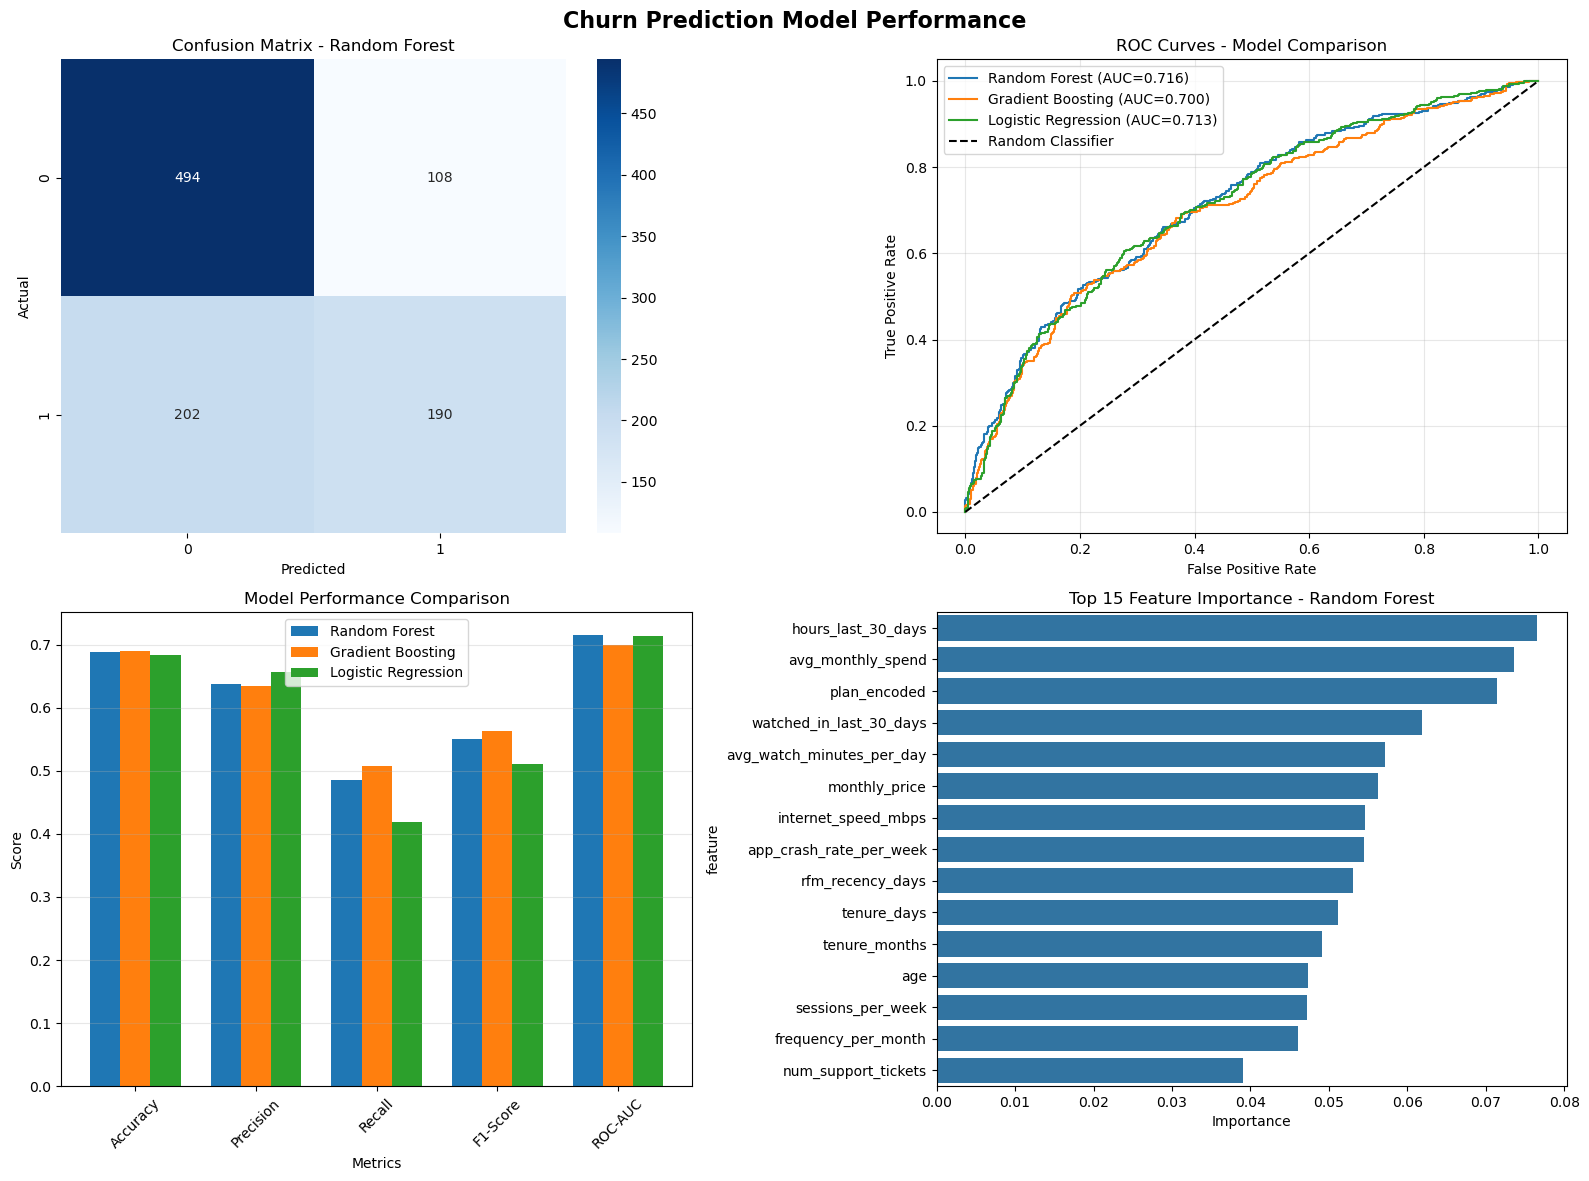


DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

    No Churn       0.71      0.82      0.76       602
       Churn       0.64      0.48      0.55       392

    accuracy                           0.69       994
   macro avg       0.67      0.65      0.66       994
weighted avg       0.68      0.69      0.68       994


HIGH-RISK CUSTOMERS (Active but likely to churn)
Found 12 high-risk customers

customer_id  tenure_months  monthly_price  avg_watch_minutes_per_day  num_complaints  churn_probability
 CUST104817           67.7            0.0                       17.1               0           0.859077
 CUST100056           30.9            0.0                       27.2               0           0.841810
 CUST104698           31.5            0.0                       12.0               0           0.837613
 CUST101809           55.5            0.0                       37.8               0           0.834664
 CUST102730           21.

In [10]:
# ===== CHURN PREDICTION MODEL =====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("CHURN PREDICTION MODEL")
print("="*70)

# Prepare features for modeling
df_model = df.copy()

# Encode categorical variables
label_encoders = {}
categorical_columns = ['gender', 'country', 'plan', 'payment_method', 
                       'fav_genre', 'acq_channel', 'contract_type', 'devices']

for col in categorical_columns:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# Select features for modeling
feature_columns = [
    'age', 'monthly_price', 'avg_watch_minutes_per_day', 'sessions_per_week',
    'num_profiles', 'watched_in_last_30_days', 'hours_last_30_days',
    'num_support_tickets', 'num_complaints', 'app_crash_rate_per_week',
    'tenure_days', 'tenure_months', 'internet_speed_mbps',
    'rfm_recency_days', 'frequency_per_month', 'avg_monthly_spend'
]

# Add encoded categorical features
feature_columns += [col + '_encoded' for col in categorical_columns if col in df_model.columns]

# Filter to available columns
feature_columns = [col for col in feature_columns if col in df_model.columns]

print(f"\n✓ Using {len(feature_columns)} features for prediction")
print(f"✓ Features: {', '.join(feature_columns[:10])}... (and {len(feature_columns)-10} more)")

X = df_model[feature_columns].fillna(0)
y = df_model['churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Training set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}

for model_name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training {model_name}...")
    print('-'*70)
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\nModel Performance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

# Compare models
print(f"\n{'='*70}")
print("MODEL COMPARISON")
print('='*70)
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).round(4)
print(comparison_df.to_string(index=False))

# Best model
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"\n✓ Best Model: {best_model_name} (ROC-AUC: {results[best_model_name]['roc_auc']:.4f})")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Churn Prediction Model Performance', fontsize=16, fontweight='bold')

# 1. Confusion Matrix for best model
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Confusion Matrix - {best_model_name}')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. ROC Curves
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_pred_proba'])
    axes[0, 1].plot(fpr, tpr, label=f"{model_name} (AUC={results[model_name]['roc_auc']:.3f})")
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves - Model Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Model Performance Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

for i, model_name in enumerate(results.keys()):
    values = [
        results[model_name]['accuracy'],
        results[model_name]['precision'],
        results[model_name]['recall'],
        results[model_name]['f1'],
        results[model_name]['roc_auc']
    ]
    axes[1, 0].bar(x + i*width, values, width, label=model_name)

axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Model Performance Comparison')
axes[1, 0].set_xticks(x + width)
axes[1, 0].set_xticklabels(metrics, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Feature Importance (for Random Forest)
if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    sns.barplot(data=feature_importance, y='feature', x='importance', ax=axes[1, 1])
    axes[1, 1].set_title(f'Top 15 Feature Importance - {best_model_name}')
    axes[1, 1].set_xlabel('Importance')
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance only available for Random Forest', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

# Detailed Classification Report
print(f"\n{'='*70}")
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print('='*70)
print(classification_report(y_test, results[best_model_name]['y_pred'], 
                          target_names=['No Churn', 'Churn']))

# Predict churn for all customers
df_model['churn_probability'] = best_model.predict_proba(
    scaler.transform(df_model[feature_columns].fillna(0))
)[:, 1]
df_model['churn_prediction'] = best_model.predict(
    scaler.transform(df_model[feature_columns].fillna(0))
)

# High-risk customers (not yet churned but high probability)
high_risk = df_model[(df_model['churn'] == 0) & 
                     (df_model['churn_probability'] > 0.7)].sort_values(
    'churn_probability', ascending=False
)

print(f"\n{'='*70}")
print(f"HIGH-RISK CUSTOMERS (Active but likely to churn)")
print('='*70)
print(f"Found {len(high_risk)} high-risk customers\n")

if len(high_risk) > 0:
    high_risk_display = high_risk[['customer_id', 'tenure_months', 'monthly_price', 
                                    'avg_watch_minutes_per_day', 'num_complaints',
                                    'churn_probability']].head(20)
    print(high_risk_display.to_string(index=False))
    
    # Save high-risk customers
    high_risk.to_csv('high_risk_customers.csv', index=False)
    print(f"\n✓ High-risk customers saved to 'high_risk_customers.csv'")

print("\n" + "="*70)
print("CHURN PREDICTION ANALYSIS COMPLETE")
print("="*70)


                    POST-CHURN PREDICTION: ACTIONABLE INSIGHTS

[STEP 1] IDENTIFYING HIGH-RISK CUSTOMERS FOR RETENTION CAMPAIGNS
--------------------------------------------------------------------------------

✓ Total Active Customers: 3,007
✓ High-Risk Customers (>70% churn probability): 12
✓ Potential Revenue at Risk: $16,006.23

Risk Segment Distribution (Active Customers):
  Low Risk............  1,751 ( 58.2%)
  Medium Risk.........  1,209 ( 40.2%)
  High Risk...........     41 (  1.4%)
  Critical Risk.......      6 (  0.2%)

✓ High-risk customer list saved to 'high_risk_customers_for_retention.csv'

[STEP 2] CUSTOMER SEGMENTATION FOR TARGETED RETENTION STRATEGIES
--------------------------------------------------------------------------------

Priority Segments for Retention:

1. HIGH-VALUE, HIGH-RISK CUSTOMERS
   Count: 5
   Avg Revenue: $44,347.85
   Total Revenue at Risk: $221,739.26
   → ACTION: Offer VIP retention deals, personal account manager

2. LOW-ENGAGEMENT, HIGH-RI

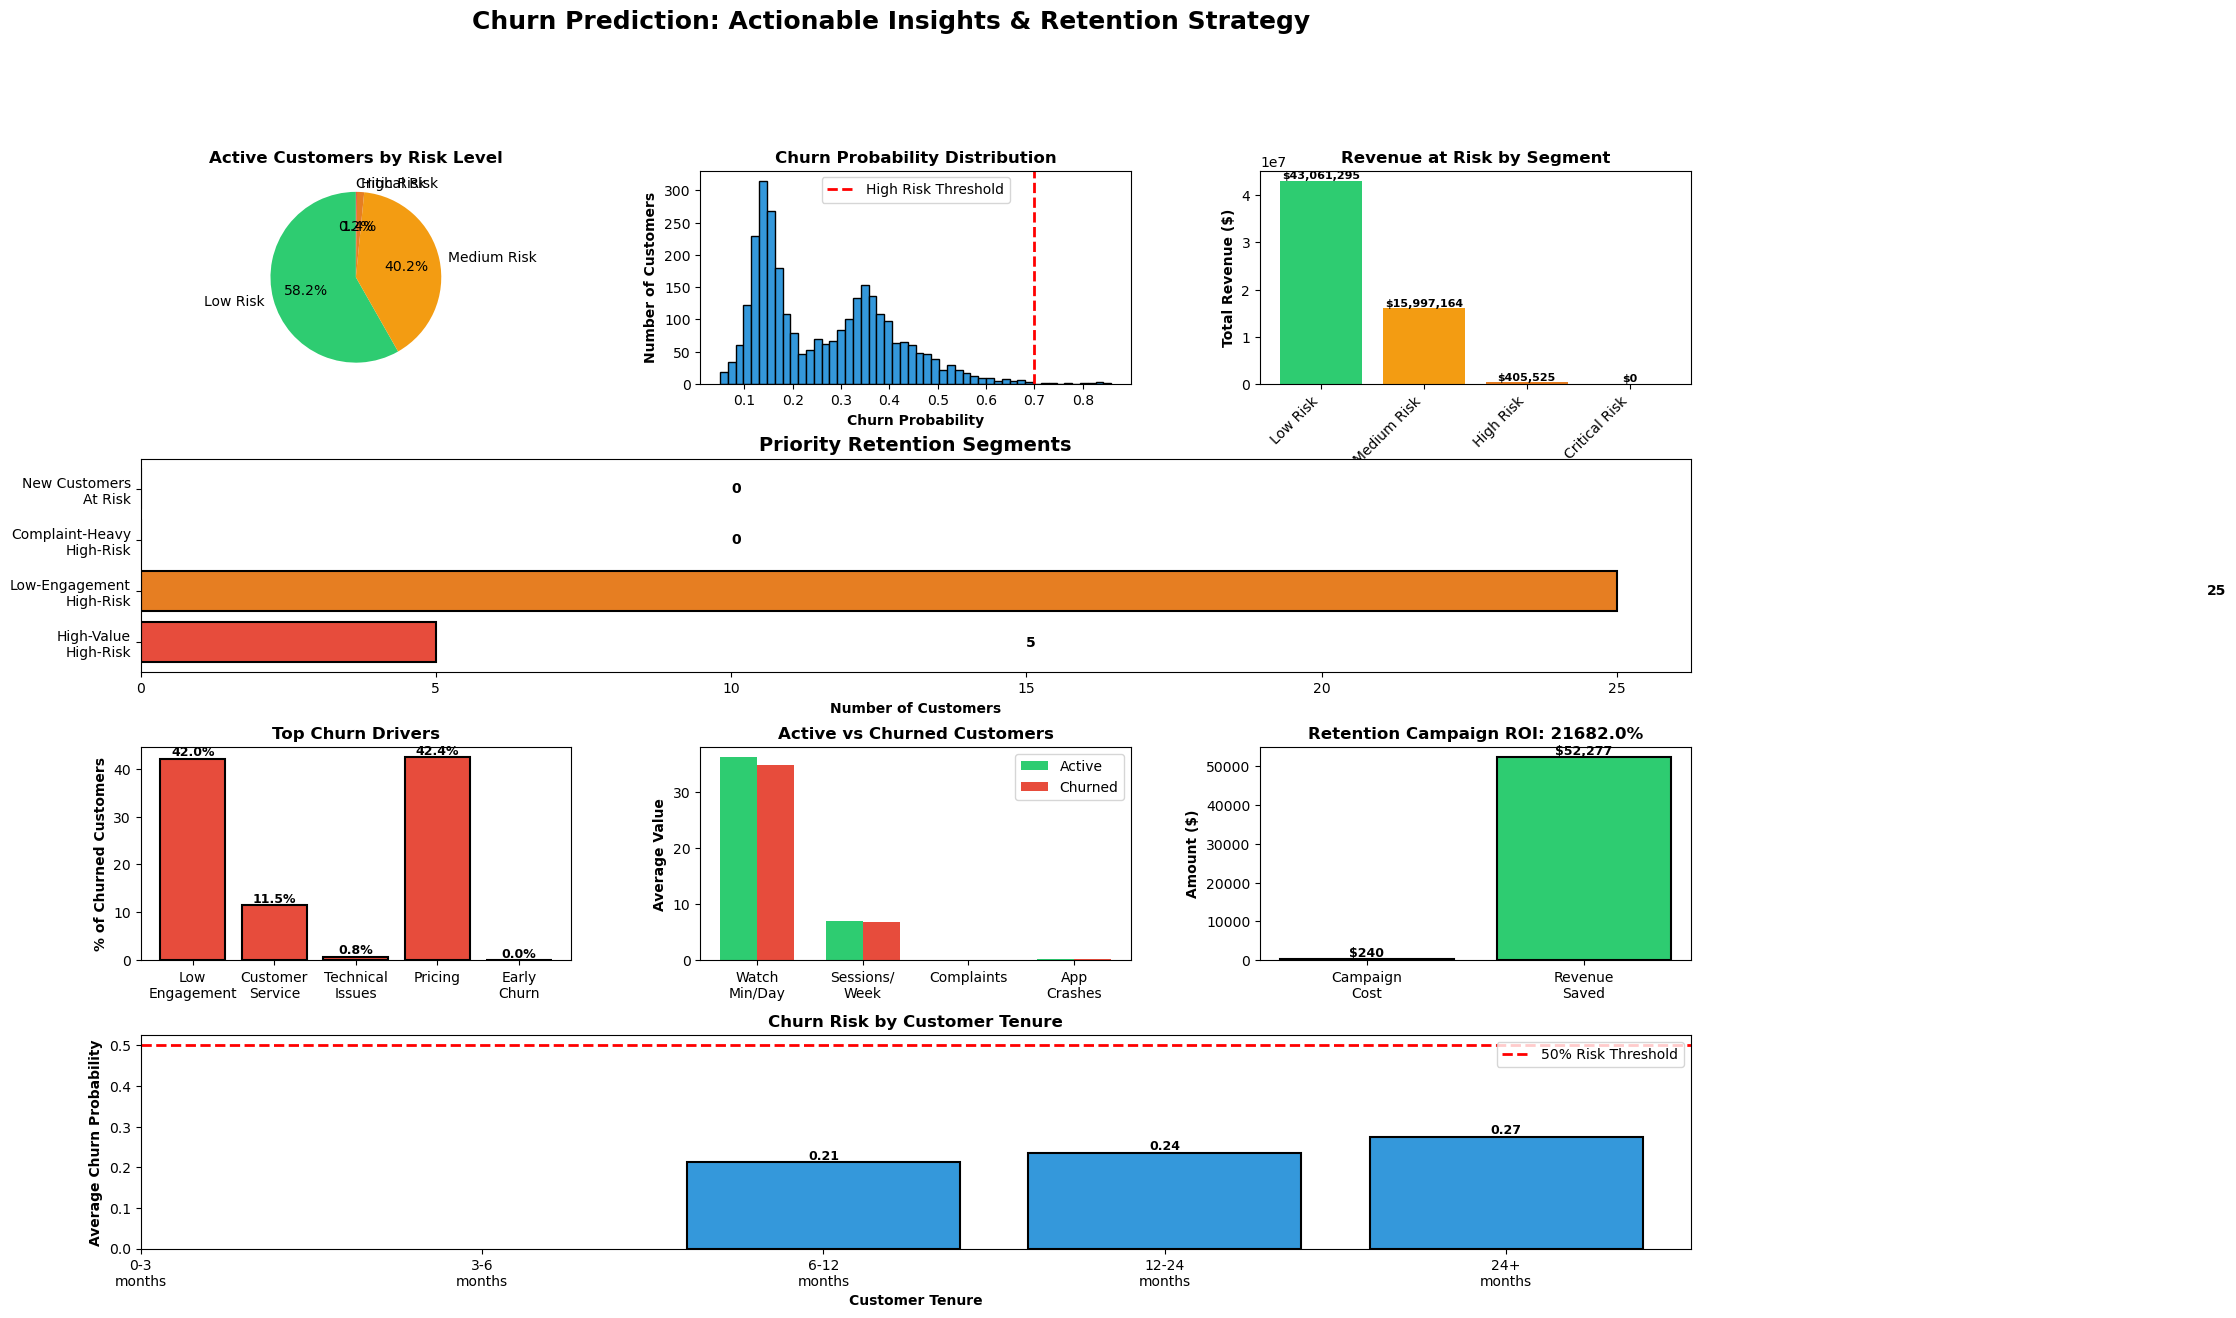


✓ Visualizations created successfully!

[STEP 7] ACTIONABLE RECOMMENDATIONS SUMMARY

┌────────────────────────────────────────────────────────────────────────────┐
│                     CHURN REDUCTION ACTION PLAN                            │
└────────────────────────────────────────────────────────────────────────────┘

📊 EXECUTIVE SUMMARY:
   • Total Customers: 4,966
   • Active Customers: 3,007
   • Churned Customers: 1,959
   • Overall Churn Rate: 39.4%
   • High-Risk Customers: 12
   • Revenue at Risk: $16,006.23

🎯 IMMEDIATE ACTIONS (Next 7 Days):
   1. Contact 5 high-value, high-risk customers personally
   2. Launch emergency retention offers for 12 critical-risk customers
   3. Fix top 3 technical issues causing app crashes
   4. Set up automated alerts for customers crossing 70% churn probability

📊 SHORT-TERM INITIATIVES (Next 30 Days):
   1. Implement personalized content for 25 low-engagement users
   2. Create win-back campaigns with special offers
   3. Improve customer

In [18]:
# ===== POST-PREDICTION ANALYSIS & ACTION PLAN (FIXED) =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print(" "*20 + "POST-CHURN PREDICTION: ACTIONABLE INSIGHTS")
print("="*80)

# ============================================================================
# IMPORTANT: Use df_model (which has encoded features) instead of df
# ============================================================================

# Add predictions to the model dataframe (which already has encoded features)
df_analysis = df_model.copy()

# Make sure we have predictions
if 'churn_probability' not in df_analysis.columns:
    print("\nGenerating predictions...")
    df_analysis['churn_probability'] = best_model.predict_proba(
        scaler.transform(df_analysis[feature_columns].fillna(0))
    )[:, 1]
    df_analysis['churn_prediction'] = best_model.predict(
        scaler.transform(df_analysis[feature_columns].fillna(0))
    )
    print("✓ Predictions generated")

# ============================================================================
# STEP 1: IDENTIFY HIGH-RISK CUSTOMERS
# ============================================================================
print("\n[STEP 1] IDENTIFYING HIGH-RISK CUSTOMERS FOR RETENTION CAMPAIGNS")
print("-"*80)

# Define risk segments
df_analysis['risk_segment'] = pd.cut(
    df_analysis['churn_probability'],
    bins=[0, 0.3, 0.6, 0.8, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
)

# Focus on active customers only
active_customers = df_analysis[df_analysis['churn'] == 0].copy()

# High-risk active customers
high_risk_customers = active_customers[
    active_customers['churn_probability'] > 0.7
].sort_values('churn_probability', ascending=False)

print(f"\n✓ Total Active Customers: {len(active_customers):,}")
print(f"✓ High-Risk Customers (>70% churn probability): {len(high_risk_customers):,}")
print(f"✓ Potential Revenue at Risk: ${high_risk_customers['total_revenue_to_date'].sum():,.2f}")

# Risk segment distribution
print("\nRisk Segment Distribution (Active Customers):")
risk_dist = active_customers['risk_segment'].value_counts()
for segment in ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']:
    count = risk_dist.get(segment, 0)
    pct = count / len(active_customers) * 100 if len(active_customers) > 0 else 0
    print(f"  {segment:.<20} {count:>6,} ({pct:>5.1f}%)")

# Save high-risk customers (only relevant columns)
save_columns = ['customer_id', 'age', 'gender', 'country', 'plan', 'monthly_price',
                'avg_watch_minutes_per_day', 'sessions_per_week', 'tenure_months',
                'num_complaints', 'num_support_tickets', 'total_revenue_to_date',
                'churn_probability', 'risk_segment']
save_columns = [col for col in save_columns if col in high_risk_customers.columns]

high_risk_customers[save_columns].to_csv('high_risk_customers_for_retention.csv', index=False)
print(f"\n✓ High-risk customer list saved to 'high_risk_customers_for_retention.csv'")

# ============================================================================
# STEP 2: CUSTOMER SEGMENTATION FOR TARGETED INTERVENTIONS
# ============================================================================
print("\n" + "="*80)
print("[STEP 2] CUSTOMER SEGMENTATION FOR TARGETED RETENTION STRATEGIES")
print("-"*80)

# Segment 1: High-Value, High-Risk (Priority 1)
segment1 = active_customers[
    (active_customers['churn_probability'] > 0.6) &
    (active_customers['total_revenue_to_date'] > active_customers['total_revenue_to_date'].quantile(0.75))
]

# Segment 2: Low-Engagement, High-Risk (Priority 2)
segment2 = active_customers[
    (active_customers['churn_probability'] > 0.6) &
    (active_customers['avg_watch_minutes_per_day'] < 30)
]

# Segment 3: Complaint-Heavy, High-Risk (Priority 3)
segment3 = active_customers[
    (active_customers['churn_probability'] > 0.6) &
    (active_customers['num_complaints'] > 1)
]

# Segment 4: New Customers at Risk (Priority 4)
segment4 = active_customers[
    (active_customers['churn_probability'] > 0.6) &
    (active_customers['tenure_months'] < 3)
]

print("\nPriority Segments for Retention:")
print(f"\n1. HIGH-VALUE, HIGH-RISK CUSTOMERS")
print(f"   Count: {len(segment1):,}")
print(f"   Avg Revenue: ${segment1['total_revenue_to_date'].mean():,.2f}")
print(f"   Total Revenue at Risk: ${segment1['total_revenue_to_date'].sum():,.2f}")
print(f"   → ACTION: Offer VIP retention deals, personal account manager")

print(f"\n2. LOW-ENGAGEMENT, HIGH-RISK CUSTOMERS")
print(f"   Count: {len(segment2):,}")
print(f"   Avg Watch Time: {segment2['avg_watch_minutes_per_day'].mean():.1f} min/day")
print(f"   → ACTION: Personalized content recommendations, re-engagement campaigns")

print(f"\n3. COMPLAINT-HEAVY, HIGH-RISK CUSTOMERS")
print(f"   Count: {len(segment3):,}")
print(f"   Avg Complaints: {segment3['num_complaints'].mean():.2f}")
print(f"   → ACTION: Priority customer service, issue resolution, apology discounts")

print(f"\n4. NEW CUSTOMERS AT RISK")
print(f"   Count: {len(segment4):,}")
print(f"   Avg Tenure: {segment4['tenure_months'].mean():.1f} months")
print(f"   → ACTION: Improve onboarding, welcome offers, engagement nudges")

# ============================================================================
# STEP 3: FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("[STEP 3] UNDERSTANDING KEY DRIVERS OF CHURN")
print("-"*80)

if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 Features Contributing to Churn:")
    for idx, row in feature_importance.head(15).iterrows():
        print(f"  {row['feature']:.<45} {row['importance']:>8.4f}")
    
    # Save feature importance
    feature_importance.to_csv('churn_feature_importance.csv', index=False)
    print(f"\n✓ Feature importance saved to 'churn_feature_importance.csv'")

# ============================================================================
# STEP 4: RETENTION STRATEGY RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("[STEP 4] RETENTION STRATEGY RECOMMENDATIONS")
print("="*80)

# Analyze churn reasons by segment
churned_customers = df_analysis[df_analysis['churn'] == 1]

print("\n📊 INSIGHTS FROM CHURNED CUSTOMERS:")
print("-"*80)

# Engagement insight
low_engagement_churn = churned_customers[churned_customers['avg_watch_minutes_per_day'] < 30]
print(f"\n1. LOW ENGAGEMENT")
print(f"   {len(low_engagement_churn)/len(churned_customers)*100:.1f}% of churned customers had low engagement (<30 min/day)")
print(f"   → Improve content discovery, personalization algorithms")

# Complaints insight
high_complaints_churn = churned_customers[churned_customers['num_complaints'] > 0]
print(f"\n2. CUSTOMER SERVICE ISSUES")
print(f"   {len(high_complaints_churn)/len(churned_customers)*100:.1f}% of churned customers had complaints")
print(f"   → Enhance customer support, faster issue resolution")

# Technical issues
high_crashes_churn = churned_customers[churned_customers['app_crash_rate_per_week'] > 1]
print(f"\n3. TECHNICAL PROBLEMS")
print(f"   {len(high_crashes_churn)/len(churned_customers)*100:.1f}% experienced frequent app crashes")
print(f"   → Fix app stability, improve quality assurance")

# Pricing insight
high_price_churn = churned_customers[churned_customers['monthly_price'] > churned_customers['monthly_price'].median()]
print(f"\n4. PRICING CONCERNS")
print(f"   {len(high_price_churn)/len(churned_customers)*100:.1f}% were on higher-priced plans")
print(f"   → Review pricing strategy, offer flexible plans")

# Early churn
early_churn = churned_customers[churned_customers['tenure_months'] < 6]
print(f"\n5. EARLY CHURN (First 6 Months)")
print(f"   {len(early_churn)/len(churned_customers)*100:.1f}% churned within 6 months")
print(f"   → Improve onboarding, first-time user experience")

# ============================================================================
# STEP 5: CALCULATE ROI OF RETENTION EFFORTS
# ============================================================================
print("\n" + "="*80)
print("[STEP 5] RETENTION CAMPAIGN ROI ANALYSIS")
print("="*80)

# Calculate potential impact
avg_customer_value = df_analysis['total_revenue_to_date'].mean()
avg_monthly_revenue = df_analysis['monthly_price'].mean()
avg_lifetime_months = df_analysis['tenure_months'].mean()

# Assume retention campaign costs and success rates
campaign_cost_per_customer = 20  # $20 per targeted customer
expected_retention_rate = 0.25  # 25% of high-risk customers can be saved

high_risk_count = len(high_risk_customers)
customers_saved = high_risk_count * expected_retention_rate
revenue_saved = customers_saved * avg_monthly_revenue * avg_lifetime_months
campaign_cost = high_risk_count * campaign_cost_per_customer
roi = (revenue_saved - campaign_cost) / campaign_cost * 100 if campaign_cost > 0 else 0

print(f"\nRetention Campaign Projections:")
print(f"  High-Risk Customers Targeted: {high_risk_count:,}")
print(f"  Campaign Cost per Customer: ${campaign_cost_per_customer:.2f}")
print(f"  Total Campaign Cost: ${campaign_cost:,.2f}")
print(f"  Expected Retention Rate: {expected_retention_rate*100:.0f}%")
print(f"  Customers Expected to Save: {customers_saved:,.0f}")
print(f"  Revenue Saved: ${revenue_saved:,.2f}")
print(f"  Net Benefit: ${revenue_saved - campaign_cost:,.2f}")
print(f"  ROI: {roi:.1f}%")

# ============================================================================
# STEP 6: CREATE VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("[STEP 6] CREATING ACTIONABLE VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 14))
fig.suptitle('Churn Prediction: Actionable Insights & Retention Strategy', 
             fontsize=18, fontweight='bold', y=0.995)

gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Risk Distribution
ax1 = fig.add_subplot(gs[0, 0])
risk_counts = active_customers['risk_segment'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
ax1.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Active Customers by Risk Level', fontweight='bold')

# 2. Churn Probability Distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(active_customers['churn_probability'], bins=50, color='#3498db', edgecolor='black')
ax2.axvline(0.7, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
ax2.set_xlabel('Churn Probability', fontweight='bold')
ax2.set_ylabel('Number of Customers', fontweight='bold')
ax2.set_title('Churn Probability Distribution', fontweight='bold')
ax2.legend()

# 3. Revenue at Risk by Segment
ax3 = fig.add_subplot(gs[0, 2])
revenue_by_risk = active_customers.groupby('risk_segment', observed=False)['total_revenue_to_date'].sum()
colors_map = {'Low Risk': '#2ecc71', 'Medium Risk': '#f39c12', 
              'High Risk': '#e67e22', 'Critical Risk': '#e74c3c'}
bars = ax3.bar(range(len(revenue_by_risk)), revenue_by_risk.values, 
               color=[colors_map.get(x, '#95a5a6') for x in revenue_by_risk.index])
ax3.set_xticks(range(len(revenue_by_risk)))
ax3.set_xticklabels(revenue_by_risk.index, rotation=45, ha='right')
ax3.set_ylabel('Total Revenue ($)', fontweight='bold')
ax3.set_title('Revenue at Risk by Segment', fontweight='bold')
for i, v in enumerate(revenue_by_risk.values):
    ax3.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 4. Priority Segments
ax4 = fig.add_subplot(gs[1, :])
segments = ['High-Value\nHigh-Risk', 'Low-Engagement\nHigh-Risk', 
            'Complaint-Heavy\nHigh-Risk', 'New Customers\nAt Risk']
segment_counts = [len(segment1), len(segment2), len(segment3), len(segment4)]
colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db']
bars = ax4.barh(segments, segment_counts, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Number of Customers', fontweight='bold')
ax4.set_title('Priority Retention Segments', fontweight='bold', fontsize=14)
for i, (bar, v) in enumerate(zip(bars, segment_counts)):
    ax4.text(v + 10, i, f'{v:,}', va='center', fontweight='bold')

# 5. Churn Drivers
ax5 = fig.add_subplot(gs[2, 0])
churn_reasons = pd.DataFrame({
    'Reason': ['Low\nEngagement', 'Customer\nService', 'Technical\nIssues', 
               'Pricing', 'Early\nChurn'],
    'Percentage': [
        len(low_engagement_churn)/len(churned_customers)*100,
        len(high_complaints_churn)/len(churned_customers)*100,
        len(high_crashes_churn)/len(churned_customers)*100,
        len(high_price_churn)/len(churned_customers)*100,
        len(early_churn)/len(churned_customers)*100
    ]
})
bars = ax5.bar(churn_reasons['Reason'], churn_reasons['Percentage'], 
               color='#e74c3c', edgecolor='black', linewidth=1.5)
ax5.set_ylabel('% of Churned Customers', fontweight='bold')
ax5.set_title('Top Churn Drivers', fontweight='bold')
for bar, v in zip(bars, churn_reasons['Percentage']):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 6. Average Metrics: Churned vs Active
ax6 = fig.add_subplot(gs[2, 1])
metrics_comparison = pd.DataFrame({
    'Metric': ['Watch\nMin/Day', 'Sessions/\nWeek', 'Complaints', 'App\nCrashes'],
    'Active': [
        active_customers['avg_watch_minutes_per_day'].mean(),
        active_customers['sessions_per_week'].mean(),
        active_customers['num_complaints'].mean(),
        active_customers['app_crash_rate_per_week'].mean()
    ],
    'Churned': [
        churned_customers['avg_watch_minutes_per_day'].mean(),
        churned_customers['sessions_per_week'].mean(),
        churned_customers['num_complaints'].mean(),
        churned_customers['app_crash_rate_per_week'].mean()
    ]
})
x = np.arange(len(metrics_comparison))
width = 0.35
ax6.bar(x - width/2, metrics_comparison['Active'], width, label='Active', color='#2ecc71')
ax6.bar(x + width/2, metrics_comparison['Churned'], width, label='Churned', color='#e74c3c')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_comparison['Metric'])
ax6.set_ylabel('Average Value', fontweight='bold')
ax6.set_title('Active vs Churned Customers', fontweight='bold')
ax6.legend()

# 7. ROI Analysis
ax7 = fig.add_subplot(gs[2, 2])
roi_data = pd.DataFrame({
    'Category': ['Campaign\nCost', 'Revenue\nSaved'],
    'Amount': [campaign_cost, revenue_saved]
})
bars = ax7.bar(roi_data['Category'], roi_data['Amount'], 
               color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Amount ($)', fontweight='bold')
ax7.set_title(f'Retention Campaign ROI: {roi:.1f}%', fontweight='bold')
for bar, v in zip(bars, roi_data['Amount']):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'${v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 8. Churn Probability by Tenure
ax8 = fig.add_subplot(gs[3, :])
tenure_bins = pd.cut(active_customers['tenure_months'], bins=[0, 3, 6, 12, 24, 100])
churn_by_tenure = active_customers.groupby(tenure_bins, observed=False)['churn_probability'].mean()
bars = ax8.bar(range(len(churn_by_tenure)), churn_by_tenure.values, 
               color='#3498db', edgecolor='black', linewidth=1.5)
ax8.set_xticks(range(len(churn_by_tenure)))
ax8.set_xticklabels(['0-3\nmonths', '3-6\nmonths', '6-12\nmonths', 
                     '12-24\nmonths', '24+\nmonths'])
ax8.set_xlabel('Customer Tenure', fontweight='bold')
ax8.set_ylabel('Average Churn Probability', fontweight='bold')
ax8.set_title('Churn Risk by Customer Tenure', fontweight='bold')
ax8.axhline(0.5, color='red', linestyle='--', linewidth=2, label='50% Risk Threshold')
ax8.legend()
for bar, v in zip(bars, churn_by_tenure.values):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
            f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.show()

print("\n✓ Visualizations created successfully!")

# ============================================================================
# STEP 7: GENERATE ACTIONABLE RECOMMENDATIONS REPORT
# ============================================================================
print("\n" + "="*80)
print("[STEP 7] ACTIONABLE RECOMMENDATIONS SUMMARY")
print("="*80)

recommendations = f"""
┌────────────────────────────────────────────────────────────────────────────┐
│                     CHURN REDUCTION ACTION PLAN                            │
└────────────────────────────────────────────────────────────────────────────┘

📊 EXECUTIVE SUMMARY:
   • Total Customers: {len(df_analysis):,}
   • Active Customers: {len(active_customers):,}
   • Churned Customers: {len(churned_customers):,}
   • Overall Churn Rate: {len(churned_customers)/len(df_analysis)*100:.1f}%
   • High-Risk Customers: {len(high_risk_customers):,}
   • Revenue at Risk: ${high_risk_customers['total_revenue_to_date'].sum():,.2f}

🎯 IMMEDIATE ACTIONS (Next 7 Days):
   1. Contact {len(segment1):,} high-value, high-risk customers personally
   2. Launch emergency retention offers for {len(high_risk_customers):,} critical-risk customers
   3. Fix top 3 technical issues causing app crashes
   4. Set up automated alerts for customers crossing 70% churn probability

📊 SHORT-TERM INITIATIVES (Next 30 Days):
   1. Implement personalized content for {len(segment2):,} low-engagement users
   2. Create win-back campaigns with special offers
   3. Improve customer service for {len(segment3):,} complaint-heavy customers
   4. Launch re-engagement email campaigns for dormant users

🚀 MEDIUM-TERM STRATEGIES (Next 90 Days):
   1. Redesign onboarding to reduce {len(segment4):,} new customer churn
   2. Implement predictive alerts in CRM system
   3. Create customer success team for high-value accounts
   4. Develop flexible pricing tiers based on usage patterns

💡 LONG-TERM IMPROVEMENTS (6+ Months):
   1. Build AI-powered personalization engine
   2. Implement real-time churn prediction monitoring
   3. Create loyalty program for long-tenure customers
   4. Invest in content acquisition for underserved genres

📈 EXPECTED IMPACT:
   • Campaign Cost: ${campaign_cost:,.2f}
   • Customers to Save: {customers_saved:,.0f}
   • Revenue Saved: ${revenue_saved:,.2f}
   • ROI: {roi:.1f}%
   • Churn Rate Reduction Target: 20%

📋 METRICS TO TRACK:
   - Monthly churn rate (baseline: {len(churned_customers)/len(df_analysis)*100:.1f}%)
   - Customer lifetime value (current: ${avg_customer_value:,.2f})
   - Retention campaign success rate (target: >25%)
   - Time to issue resolution (target: <24 hours)
   - Customer satisfaction score (target: >4.5/5)

🎯 TOP CHURN DRIVERS TO ADDRESS:
   1. Low Engagement: {len(low_engagement_churn)/len(churned_customers)*100:.1f}% of churned customers
   2. Customer Service Issues: {len(high_complaints_churn)/len(churned_customers)*100:.1f}% had complaints
   3. Technical Problems: {len(high_crashes_churn)/len(churned_customers)*100:.1f}% had app crashes
   4. Pricing Concerns: {len(high_price_churn)/len(churned_customers)*100:.1f}% on high-priced plans
   5. Early Churn: {len(early_churn)/len(churned_customers)*100:.1f}% churned within 6 months
"""

print(recommendations)

# Save summary report
with open('churn_prediction_action_plan.txt', 'w', encoding='utf-8') as f:
    f.write(recommendations)

print("\n✓ Action plan saved to 'churn_prediction_action_plan.txt'")

print("\n" + "="*80)
print("✅ POST-PREDICTION ANALYSIS COMPLETE!")
print("="*80)
print("\nFiles Generated:")
print("  1. high_risk_customers_for_retention.csv")
print("  2. churn_feature_importance.csv")
print("  3. churn_prediction_action_plan.txt")
print("\nNext Steps:")
print("  → Share high-risk customer list with retention team")
print("  → Present insights to management")
print("  → Implement recommended retention strategies")
print("  → Monitor and measure campaign effectiveness")
print("="*80)

In [20]:
df.to_csv("C:/Users/Admin/Downloads/final_clean_ott_data.csv", index=False)
